In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

## 1D Transient Heat Conduction

In [167]:
# Initialize parameters of the question
k = 50 # Thermal conductivity, W/K
L = 0.1 # m
A = 75e-6 # m^2
cp = 700 # Specific heat capacity, J/(kg * K)
rho = 200 # kg/m^3
# C = cp*rho # J/K, volume specific
alpha = k/(rho*cp) # thermal diffusivity, m^2/s
print(alpha)

# Drichlet boundary conditions
T_L = 390 # K, x=0
T_R = 290 # K, x=L


0.00035714285714285714


In [168]:
# discretize the space
n_elem = 10
n_nodes = n_elem + 1
l_elem = L/n_elem
dx = l_elem
elem_x = np.linspace(l_elem/2, L-l_elem/2, n_elem)
nodes_x = np.linspace(0, L, n_nodes)
print("Positions of nodes", nodes_x)

n_dof = n_elem # degree of freedom of the system

CON = [] # connectivity
for i in range(n_elem):
    CON.append([i, i+1])
print("Connectivty", CON)

class Element:
    def __init__(self, nodes, x, k, cp, rho, l):
        self.nodes = nodes
        self.x = x
        self.k = k
        self.cp = cp
        self.rho = rho
        self.l = l

    def __repr__(self):
        return f"Element(nodes={self.nodes})"

# create elements
elements = []
for i in range(n_elem):
    x = l_elem*(i+0.5)
    elements.append(Element(CON[i], elem_x[i], k, cp, rho, l_elem))

print("Elements", elements)

Positions of nodes [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
Connectivty [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
Elements [Element(nodes=[0, 1]), Element(nodes=[1, 2]), Element(nodes=[2, 3]), Element(nodes=[3, 4]), Element(nodes=[4, 5]), Element(nodes=[5, 6]), Element(nodes=[6, 7]), Element(nodes=[7, 8]), Element(nodes=[8, 9]), Element(nodes=[9, 10])]


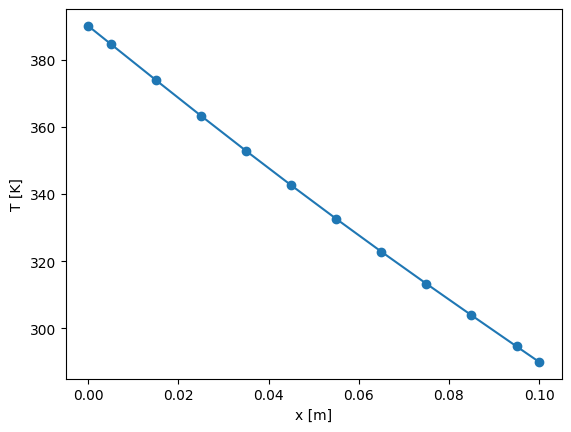

In [173]:
# discretize the time
t_final = 10
dt = 0.1
t = np.arange(0, t_final, dt)

# creating temperature values
T_0 = 273 # K, initial temperature
T = np.ones(n_dof) * T_0 # for two BC
dTdt = np.zeros(n_dof)

T_log = np.zeros((len(t), n_dof))
T_log[0] = T

plt.figure(1)

for j in range(len(t)):
    for i in range(n_dof):
        element = elements[i]
        alpha = element.k/(element.rho*element.cp)

        if i == 0: # left BC
            dTdt[i] = alpha*(
                -(T[i]-T_L)/(0.5*element.l**2)
                +(T[i+1]-T[i])/element.l**2
                )
        elif i == n_dof-1: # right bC
            dTdt[i] = alpha*(
                (T[i-1]-T[i])/element.l**2
                +(T_R-T[i])/(0.5*element.l**2)
                )
        else:
            dTdt[i] = alpha*(T[i+1]-2*T[i]+T[i-1])/element.l**2
    T = T + dTdt*dt
    T_log[j] = T

    plt.clf()
    plt.plot([0, *elem_x, L], [T_L, *T, T_R], marker="o")
    plt.xlabel("x [m]")
    plt.ylabel("T [K]")
    plt.show()
    display.clear_output(wait=True)


## 2D Heat Conduction

In [209]:
# properties
L = 1 # m
k = 50 # Thermal conductivity, W/K
cp = 700 # Specific heat capacity, J/(kg * K)
rho = 200 # kg/m^3

# domain discretization
n_elem = 20 # in 1 direction
dx = dy = L/(n_elem+2)
# elem_x = np.linspace(dx/2, L-dx/2, n_elem) # to use this type of mesh, code should chane
# elem_y = np.linspace(dy/2, L-dy/2, n_elem)
elem_x = np.linspace(0, L, n_elem+2)
elem_y = np.linspace(0, L, n_elem+2)

elem_coords = np.array([(x, y) for x in elem_x for y in elem_y])
elem_coords[:5,:]

array([[0.        , 0.        ],
       [0.        , 0.04761905],
       [0.        , 0.0952381 ],
       [0.        , 0.14285714],
       [0.        , 0.19047619]])

In [212]:
# temperature values
T = np.zeros((n_elem+2, n_elem+2))
T[0,:] = 1

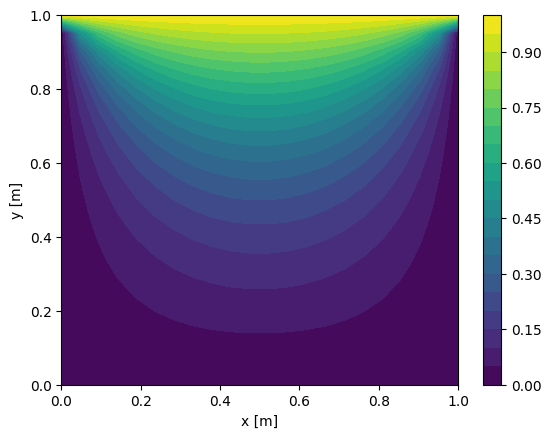

In [223]:
# time integration
dt = 0.1
t_final = 20
t = np.arange(0, t_final, dt)

for j in range(len(t)):
    for i in range(1,n_elem+1):
        for j in range(1,n_elem+1):
            a_e = k/dx
            a_w = k/dx
            a_s = k/dy
            a_n = k/dy
            a_p = a_e + a_w + a_s + a_n
            T[i,j] = (a_e*T[i,j+1] + a_w*T[i,j-1] + a_s*T[i-1,j] + a_n*T[i+1,j])/a_p
# plot 2d map of temperaturs
plt.figure(1)
X, Y = np.meshgrid(elem_x, L-elem_y)
plt.contourf(X, Y, T, 20)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar()
plt.show()